# Modelling
<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* Ridge and Lasso Regularization (add on to linear modelling?)

<u> Tests using the following variables:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables:
    * Sensor_id
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   


Normalise variables: should this be with MinMax or StandardScaler??


Process:
* Keep only data from sensor's with relatively complete data
* Split data into training ( 75%) and test (25%)
* Define the models to use in testing (linear regression, random forest, xgboost)
* Define the error metrics to use in evaluating the model performance

In [2]:
import pandas as pd
from eli5.sklearn import PermutationImportance
import joblib 
from Functions import *

In [3]:
buffer_size_m=50

### Load the fitted model

In [4]:
rf_model_pipeline1 = joblib.load('PickleFiles/FinalModels/rf_model_pipeline1_combined_features_().pkl'.format(buffer_size_m))
# rf_model_pipeline2 = joblib.load('PickleFiles/rf_model_pipeline2_combined_features.fit.sav')
# rf_model_pipeline3 = joblib.load('PickleFiles/rf_model_pipeline3_combined_features.fit.sav')

### Load the data used to fit model

In [30]:
Xfull = pd.read_csv('PickleFiles/FinalModels/Xfull_rf_model_pipeline1_combined_features_().csv'.format(buffer_size_m))
Yfull = pd.read_csv('PickleFiles/FinalModels/Yfull_rf_model_pipeline1_combined_features_().csv'.format(buffer_size_m))
Yfull = Yfull["0"].to_numpy()

### Find Gini impurity feature importances
Gini feature importance (or mean decrease in impurity) counts the number of times a feature is used to split a node, weighted by the number of samples it splits.

In [ ]:
gi_1 = find_gini_importance(Xfull,rf_model_pipeline1['rf_regressor'])    
# gi_2 = find_gini_importance(rf_model_pipeline2['rf_regressor'])   
# gi_3 = find_gini_importance(rf_model_pipeline3['rf_regressor'])   

### Find the permutation importances

In [31]:
pi_1, pi_1_raw = find_permutation_importance(rf_model_pipeline1['rf_regressor'], Xfull, Yfull, n_iter=3)    
# pi_2, pi_2_raw = find_permutation_importance(rf_model_pipeline2['rf_regressor'], Xfull, Yfull, n_iter=3)     
# pi_3, pi_3_raw = find_permutation_importance(rf_model_pipeline3['rf_regressor'], Xfull, Yfull, n_iter=3)  

### Plot and compare feature importances

In [ ]:
# cardinality_df = pd.DataFrame({'feature':Xfull.columns, 'n_features':Xfull.nunique()})
# cardinality_df = cardinality_df.merge(pi_1, on='feature', how='outer')
# cardinality_df = cardinality_df.drop([0,1,2,4, 45])
# plt.scatter(cardinality_df['n_features'], cardinality_df['importance'])
# # plt.scatter(cardinality_df[:-2]['n_features'], cardinality_df[:-2]['importance'])
# # cardinality_df

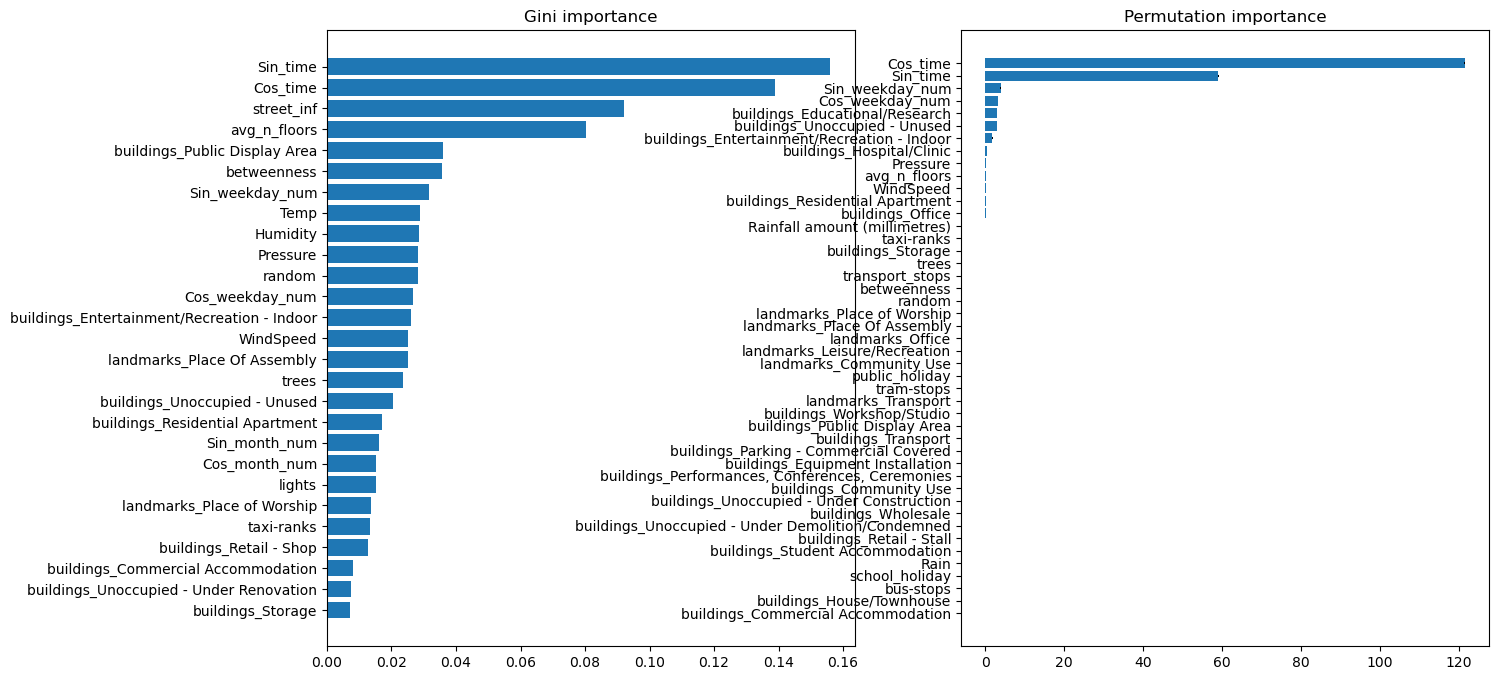

In [36]:
fig, axs = plt.subplots(ncols = 2, figsize=(15,8))
plot_compare_importances(axs, gi_1, pi_1, above_random_cat='random_cat')   

# fig, axs = plt.subplots(ncols = 2, figsize=(15,8))
# plot_compare_importances(axs, gi_2, pi_2, above_random_cat='random_cat')   

# fig, axs = plt.subplots(ncols = 2, figsize=(15,8))
# plot_compare_importances(axs, gi_3, pi_3, above_random_cat='random_cat')   